In [80]:
from sys import path
if '..' not in path:
    path.insert(0, '..')

In [81]:
from os import path, makedirs, environ
import numpy as np
import random
import json
from datetime import datetime

In [82]:
seed = 101
environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed) 
random.seed(seed)

### [ONLY FOR DEBUG] Turnaround to use the CPU (instead of the GPU)

In [83]:
use_gpu = True

In [84]:
from os import environ
if not use_gpu:
    environ["CUDA_VISIBLE_DEVICES"] = ""

# Other imports

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import _library.lstm_utils as lstm_utils
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import set_memory_growth

In [86]:
if use_gpu:
    display(list_physical_devices())
    print("Num GPUs Available: ", len(list_physical_devices('GPU')))
    physical_devices = list_physical_devices('GPU')
    set_memory_growth(physical_devices[0], enable=True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Num GPUs Available:  1


In [87]:
from _library.utils import SYSTEM_NAMES, SUBFOLDERS, load_datasets
from tensorflow.random import set_seed as tf_set_seed
from string import ascii_uppercase 
from collections import Counter
from re import match, findall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model  
from tensorflow.keras import metrics as metrics
from sklearn.ensemble import ExtraTreesClassifier
from datetime import datetime

In [88]:
tf_set_seed(seed)

In [89]:
%cd /mnt/data/vieri/projects/SAMPLE/

/mnt/data/vieri/projects/SAMPLE


# 1) The photovoltaic systems

In [90]:
print(SYSTEM_NAMES, "\nSUBFOLDERS: -->", SUBFOLDERS)
# --- 0 ---------- 1 ---------- 2 --------- 3 ---------- 4 -------

['Binetto 1', 'Binetto 2', 'Soleto 1', 'Soleto 2', 'Galatina'] 
SUBFOLDERS: --> ['Cleaned', '1-hour sampling', '1-hour averaged sampling', 'Residuals', 'Residuals_analytical', 'Failure events', None]


## 1.1) Selecting the PV system

In [91]:
system_name = SYSTEM_NAMES[3]

In [92]:
system_path = path.join('data', system_name.upper(), system_name.upper())
print(f"PV SYSTEM --> {system_name}")

PV SYSTEM --> Soleto 2


## 1.2) Load the failure logs

In [93]:
data_folder = 'Failure events'

In [94]:
file_name = 'HighMedium_failureEvent_logs.csv'

In [95]:
folder_path = path.join(system_path, 'Imported data' , data_folder)
fault_df, unique_events = lstm_utils.load_failure_logs(folder_path, file_name, system_name, verbose = True)

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- SOLETO 2 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
Logs concerning failure events have been loaded.

---------------------------------------- DATA AVAILABLE ----------------------------------------
--> Inverter available (2):  1, 2
--> Unique events (3)
	--> 1) (HIGH) Isolamento
	--> 2) (HIGH) String-box con corrente a 0
	--> 3) (MEDIUM) Corrente di stringa fuori range

--> Unique string names available (12): s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12

--> General Plant box available (12):
	--> QC1.I1
	--> QC1.I2
	--> QC2.I1
	--> QC2.I2
	--> QC3.I1
	--> QC3.I2
	--> QC4.I1
	--> QC4.I2
	--> QC5.I1
	--> QC5.I2
	--> QC6.I1
	--> QC6.I2


# 2) Explore the data

## 2.1) The dataframe

In [96]:
print("-" * 110 + "\n" + "-" * 50, system_name.upper(), "-" * 50 + "\n" + "-" * 110)

print("\n", "-" * 40, 'FEATURES', "-" * 40)
fault_df.info()
print("\n" + "-" * 20, f'LOG EXAMPLES (COVERED PERIOD: FROM {fault_df["Inizio"].iloc[0].strftime("%Y-%m-%d")} '\
        f'TO {fault_df["Inizio"].iloc[-1].strftime("%Y-%m-%d")})', "-" * 20)
display(fault_df)

cond = fault_df['Inverter'] == 2
cond2 = fault_df['Messaggio'] == 'Allarme fusibile su polo negativo'

display(fault_df[cond & cond2])

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- SOLETO 2 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------

 ---------------------------------------- FEATURES ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29306 entries, 0 to 29305
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   Inverter         29303 non-null  Int64          
 1   Quadro Generale  29303 non-null  object         
 2   Stringa          29072 non-null  object         
 3   Tipo             29306 non-null  object         
 4   Causa Guasto     29306 non-null  object         
 5   Messaggio        29306 non-null  object         
 6   Durata           29306 non-nu

,Inverter,Quadro Generale,Stringa,Tipo,Causa Guasto,Messaggio,Durata,Inizio,Fine
0,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
1,1,QC4.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
2,1,QC3.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
3,1,QC2.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
4,2,QC3.I2,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:11:00,2016-05-18 12:34:00,2016-05-18 12:45:00
...,...,...,...,...,...,...,...,...,...
29301,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:07:00,2021-09-13 11:47:00,2021-09-13 11:54:00
29302,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:23:00,2021-09-13 12:04:00,2021-09-13 12:27:00
29303,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2021-09-13 12:32:00,2021-09-13 12:44:00
29304,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 04:05:00,2021-09-13 12:49:00,2021-09-13 16:54:00


,Inverter,Quadro Generale,Stringa,Tipo,Causa Guasto,Messaggio,Durata,Inizio,Fine


## 2.2) Visualize the grouped failure events

In [97]:
display(fault_df.groupby(by = ['Quadro Generale', 'Stringa']).count())

Inverter  Tipo  Causa Guasto  Messaggio  Durata  \
Quadro Generale Stringa                                                    
QC1.I1          s1            227   227           227        227     227   
                s10           184   184           184        184     184   
                s11            81    81            81         81      81   
                s12            27    27            27         27      27   
                s2            179   179           179        179     179   
...                           ...   ...           ...        ...     ...   
QC6.I2          s5            165   165           165        165     165   
                s6             22    22            22         22      22   
                s7             15    15            15         15      15   
                s8             78    78            78         78      78   
                s9             20    20            20         20      20   

                         Inizio  Fine  
Quadro Generale Stringa                
QC1.I1          s1          227   227  
                s10         184   184  
                s11          81    81  
                s12          27    27  
                s2          179   179  
...                         ...   ...  
QC6.I2          s5          165   165  
                s6           22    22  
                s7           15    15  
                s8           78    78  
                s9           20    20  

[124 rows x 7 columns]

In [98]:
groups = [
    ['Inverter',  'Tipo', 'Messaggio'], 
    ['Tipo', 'Messaggio']
]

In [99]:
print("-" * 110 + "\n" + "-" * 50, system_name.upper(), "-" * 50 + "\n" + "-" * 110, "\n")
for idk, cols_to_group_by in enumerate(groups):
    print("-" * 52 + "\n" + "-" * 22, f"VIEW {idk + 1}", "-" * 22 + "\n" + "-" * 52)
    
        # Filtered by the first data available in the inverter
    if system_name == 'Soleto 1':
        inv_first_ts = pd.to_datetime('2018-08-08 11:00:00')
    elif system_name == 'Soleto 2':
        inv_first_ts = pd.to_datetime('2018-08-08 15:00:00')
    elif system_name == 'Galatina':
        inv_first_ts = pd.to_datetime('2019-08-12 18:00:00')
        
    #fault_df = fault_df[fault_df['Inizio'] >= inv_first_ts]
    
    print(f"COLUMNS USED TO GROUP ({len(cols_to_group_by)}): ", ', '.join(cols_to_group_by))
    grouped_fault_df = fault_df.groupby(by = cols_to_group_by)['Durata'].agg(['count', 'mean', 'median', 'max', 'min', 'sum'])
    grouped_fault_df.rename(columns = {'sum': 'Summed period', 
                                       'count' : 'Total events',
                                       'mean' : 'Avgerage event duration',
                                       'median': 'Median event duration', 
                                       'max': 'Maxiumum event duration',
                                       'min': 'Minimum event duration'}, 
                            inplace = True)
    grouped_fault_df['Avgerage event duration'] = grouped_fault_df['Avgerage event duration'].apply(lambda ts: ts.round('s'))
    grouped_fault_df = grouped_fault_df.astype(str)
    
    display(fault_df)
    timestamps = sorted(fault_df['Inizio'].values)
    period_df = pd.DataFrame(
        data = [pd.to_datetime(timestamps[0]),pd.to_datetime(timestamps[-1]),
                pd.to_datetime(timestamps[-1]) - pd.to_datetime(timestamps[0])],
        index = ['First', 'Last', 'Total days'],
        columns = ['Period']
    )
    
    # Save the view
    file_name = system_name + " - StringBoxes_frequencies_.xlsx"
    save_folder_path = path.join("./data", system_name.upper(), system_name.upper(), "Fault analyses")
    
    if not path.exists(save_folder_path):
        makedirs(save_folder_path)
        print("A new saving folder has been created")
    
    #writer = pd.ExcelWriter(path.join(save_folder_path, file_name))
    
    #period_df.to_excel(writer,sheet_name = "Info", freeze_panes = (1, 0))
    #grouped_fault_df.to_excel(writer, sheet_name = "Grouped events", freeze_panes = (1, 3))
    
    #writer.save()
    #print(f"Frequencies have been saved into {save_folder_path}")

    display(period_df)
    print('grouped_fault_df')
    display(grouped_fault_df)

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- SOLETO 2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

----------------------------------------------------
---------------------- VIEW 1 ----------------------
----------------------------------------------------
COLUMNS USED TO GROUP (3):  Inverter, Tipo, Messaggio


,Inverter,Quadro Generale,Stringa,Tipo,Causa Guasto,Messaggio,Durata,Inizio,Fine
0,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
1,1,QC4.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
2,1,QC3.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
3,1,QC2.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
4,2,QC3.I2,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:11:00,2016-05-18 12:34:00,2016-05-18 12:45:00
...,...,...,...,...,...,...,...,...,...
29301,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:07:00,2021-09-13 11:47:00,2021-09-13 11:54:00
29302,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:23:00,2021-09-13 12:04:00,2021-09-13 12:27:00
29303,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2021-09-13 12:32:00,2021-09-13 12:44:00
29304,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 04:05:00,2021-09-13 12:49:00,2021-09-13 16:54:00


,Period
First,2016-05-18 12:33:00
Last,2021-09-14 08:50:00
Total days,1944 days 20:17:00


grouped_fault_df


Total events  \
Inverter Tipo                   Messaggio                                      
1        Log_stringBox - High   Isolamento                                36   
                                String-box con corrente a 0               87   
         Log_stringBox - Medium Corrente di stringa fuori range        10596   
2        Log_stringBox - High   String-box con corrente a 0              108   
         Log_stringBox - Medium Corrente di stringa fuori range        18476   

                                                                Avgerage event duration  \
Inverter Tipo                   Messaggio                                                 
1        Log_stringBox - High   Isolamento                              0 days 00:17:13   
                                String-box con corrente a 0             7 days 03:53:19   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:21:46   
2        Log_stringBox - High   String-box con corrente a 0             6 days 12:54:14   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:43:03   

                                                                Median event duration  \
Inverter Tipo                   Messaggio                                               
1        Log_stringBox - High   Isolamento                            0 days 00:11:00   
                                String-box con corrente a 0           0 days 16:46:00   
         Log_stringBox - Medium Corrente di stringa fuori range       0 days 00:12:00   
2        Log_stringBox - High   String-box con corrente a 0           0 days 16:54:30   
         Log_stringBox - Medium Corrente di stringa fuori range       0 days 00:12:00   

                                                                Maxiumum event duration  \
Inverter Tipo                   Messaggio                                                 
1        Log_stringBox - High   Isolamento                              0 days 00:43:00   
                                String-box con corrente a 0           135 days 03:48:00   
         Log_stringBox - Medium Corrente di stringa fuori range         1 days 03:03:00   
2        Log_stringBox - High   String-box con corrente a 0           142 days 04:05:00   
         Log_stringBox - Medium Corrente di stringa fuori range         1 days 03:09:00   

                                                                Minimum event duration  \
Inverter Tipo                   Messaggio                                                
1        Log_stringBox - High   Isolamento                             0 days 00:11:00   
                                String-box con corrente a 0            0 days 00:05:00   
         Log_stringBox - Medium Corrente di stringa fuori range        0 days 00:05:00   
2        Log_stringBox - High   String-box con corrente a 0            0 days 00:06:00   
         Log_stringBox - Medium Corrente di stringa fuori range        0 days 00:05:00   

                                                                     Summed period  
Inverter Tipo                   Messaggio                                           
1        Log_stringBox - High   Isolamento                         0 days 10:20:00  
                                String-box con corrente a 0      623 days 02:19:00  
         Log_stringBox - Medium Corrente di stringa fuori range  160 days 02:38:00  
2        Log_stringBox - High   String-box con corrente a 0      706 days 01:37:00  
         Log_stringBox - Medium Corrente di stringa fuori range  552 days 07:22:00

----------------------------------------------------
---------------------- VIEW 2 ----------------------
----------------------------------------------------
COLUMNS USED TO GROUP (2):  Tipo, Messaggio


,Inverter,Quadro Generale,Stringa,Tipo,Causa Guasto,Messaggio,Durata,Inizio,Fine
0,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
1,1,QC4.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
2,1,QC3.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
3,1,QC2.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-18 12:33:00,2016-05-18 12:45:00
4,2,QC3.I2,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:11:00,2016-05-18 12:34:00,2016-05-18 12:45:00
...,...,...,...,...,...,...,...,...,...
29301,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:07:00,2021-09-13 11:47:00,2021-09-13 11:54:00
29302,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:23:00,2021-09-13 12:04:00,2021-09-13 12:27:00
29303,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2021-09-13 12:32:00,2021-09-13 12:44:00
29304,1,QC1.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 04:05:00,2021-09-13 12:49:00,2021-09-13 16:54:00


,Period
First,2016-05-18 12:33:00
Last,2021-09-14 08:50:00
Total days,1944 days 20:17:00


grouped_fault_df


Total events  \
Tipo                   Messaggio                                      
General Fault          fusibili stringhe                          1   
                       moduli FV                                  2   
Log_stringBox - High   Isolamento                                36   
                       String-box con corrente a 0              195   
Log_stringBox - Medium Corrente di stringa fuori range        29072   

                                                       Avgerage event duration  \
Tipo                   Messaggio                                                 
General Fault          fusibili stringhe                       0 days 02:00:00   
                       moduli FV                               0 days 06:30:00   
Log_stringBox - High   Isolamento                              0 days 00:17:13   
                       String-box con corrente a 0             6 days 19:35:22   
Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:35:17   

                                                       Median event duration  \
Tipo                   Messaggio                                               
General Fault          fusibili stringhe                     0 days 02:00:00   
                       moduli FV                             0 days 06:30:00   
Log_stringBox - High   Isolamento                            0 days 00:11:00   
                       String-box con corrente a 0           0 days 16:46:00   
Log_stringBox - Medium Corrente di stringa fuori range       0 days 00:12:00   

                                                       Maxiumum event duration  \
Tipo                   Messaggio                                                 
General Fault          fusibili stringhe                       0 days 02:00:00   
                       moduli FV                               0 days 09:00:00   
Log_stringBox - High   Isolamento                              0 days 00:43:00   
                       String-box con corrente a 0           142 days 04:05:00   
Log_stringBox - Medium Corrente di stringa fuori range         1 days 03:09:00   

                                                       Minimum event duration  \
Tipo                   Messaggio                                                
General Fault          fusibili stringhe                      0 days 02:00:00   
                       moduli FV                              0 days 04:00:00   
Log_stringBox - High   Isolamento                             0 days 00:11:00   
                       String-box con corrente a 0            0 days 00:05:00   
Log_stringBox - Medium Corrente di stringa fuori range        0 days 00:05:00   

                                                             Summed period  
Tipo                   Messaggio                                            
General Fault          fusibili stringhe                   0 days 02:00:00  
                       moduli FV                           0 days 13:00:00  
Log_stringBox - High   Isolamento                          0 days 10:20:00  
                       String-box con corrente a 0      1329 days 03:56:00  
Log_stringBox - Medium Corrente di stringa fuori range   712 days 10:00:00

# 3) Data preparation

## 3.1) Create the dataframe using the new concept

In [100]:
# QCx -- > classico allarme sullo stringbox
# QCx_strings_time --> Somma degli allarmi delle sue stringhe per quel ora. 
# QCx_faulty_strings --> rapporto delle stringhe difettose in quel ora sul totale 

In [101]:
prefix_gb = "QC"

In [102]:
starting_ts = fault_df['Inizio'].iloc[0].strftime('%Y-%m-%d %H')
ending_ts = pd.to_datetime(fault_df['Fine'].iloc[-1].strftime('%Y-%m-%d %H')) + pd.Timedelta(1, unit = 'hour')
timestamps = pd.date_range(starting_ts, ending_ts, freq = "1H")

In [103]:
main_folder_path =  path.join('data',system_name.upper(), system_name.upper(), "UC2 - LSTM")
file_path = path.join(main_folder_path, 'Params', 'stringBoxes_config.json')
try: 
    with open(file_path, 'r') as json_reader:
        stringBoxes_config = json.load(json_reader)
except FileNotFoundError:
    print(f'ISSUE! File not found. A configuration of the string boxes of {system_name} must be provided')
display(stringBoxes_config)

{'QC1': {'num_strings': 12},
 'QC2': {'num_strings': 10},
 'QC3': {'num_strings': 10},
 'QC4': {'num_strings': 10},
 'QC5': {'num_strings': 10},
 'QC6': {'num_strings': 10}}

In [104]:
# Columns
num_generalBoxes = len(stringBoxes_config.keys())
max_num_strings = np.max([stringBoxes_config[sb]['num_strings'] for sb in stringBoxes_config.keys()])

names = [f'{prefix_gb}{gb}' for gb in range(1, num_generalBoxes + 1)]
names.extend([f'{prefix_gb}{gb}_strings_time' for gb in range(1, num_generalBoxes + 1)])
names.extend([f'{prefix_gb}{gb}_faulty_strings' for gb in range(1, num_generalBoxes + 1)])

# Add a column for the labels (i.e., array that contains the alarm high)
output_col_name = 'Labels'
names.insert(0, output_col_name)

# Create input/output columns
input_classes = [event for event, priority in unique_events.items() if priority == 'medium']
output_classes = [event for event, priority in unique_events.items() if priority == 'high']

display(names)

['Labels',
 'QC1',
 'QC2',
 'QC3',
 'QC4',
 'QC5',
 'QC6',
 'QC1_strings_time',
 'QC2_strings_time',
 'QC3_strings_time',
 'QC4_strings_time',
 'QC5_strings_time',
 'QC6_strings_time',
 'QC1_faulty_strings',
 'QC2_faulty_strings',
 'QC3_faulty_strings',
 'QC4_faulty_strings',
 'QC5_faulty_strings',
 'QC6_faulty_strings']

### Generate the inverter names

In [105]:
prefix_inv_name = 'INV'

In [106]:
num_inverters = 4 if (system_name != 'Soleto 2') else 2
inv_names = [prefix_inv_name + str(inv_num) for inv_num in range(1, num_inverters + 1)]

## 3.2) Fill the new dataframe

### 3.2.1) Fill the space for each inverter

In [107]:
skip_inv_without_high_alarms = False

In [108]:
inv_stringBoxes_data = dict()

for inv_name in inv_names.copy():
    print("\n" + "-" * 40, inv_name, "-" * 40)

    # 1) Retrieve the failure events concerning the inverter 
    inv_num = int(inv_name[-1])
    inv_alarms = fault_df[fault_df['Inverter'] == inv_num]#.iloc[:10]
    #display(inv_alarms)
    
    # 1.2) Chech whethere there are alarms with high priority
    if skip_inv_without_high_alarms:
        has_high_alarms = True if len([type_name for type_name in inv_alarms['Tipo'].unique() 
                                       if 'HIGH' in type_name.upper()]) > 0 else False
        if not has_high_alarms:
            print(f"\t[{inv_name}] it does not have any log concerning high-priority alarms.")
            inv_names.remove(inv_name)
            continue
    
    # 2) Create the empty dataframe
    print("a) Generating the new space ...")
    inv_stringBoxes_data[inv_name] = pd.DataFrame(data = np.zeros(shape = (len(timestamps), len(names))), 
                                                  index = timestamps, columns = names)
    inv_stringBoxes_data[inv_name] = inv_stringBoxes_data[inv_name].applymap(lambda cell: 
                                                                             np.zeros(len(input_classes), dtype = int))
    inv_stringBoxes_data[inv_name].loc[:, output_col_name] = inv_stringBoxes_data[inv_name][output_col_name].apply(
        lambda cell: np.zeros(len(output_classes), dtype = int))
    
    faulty_cols = [col_name for col_name in names if 'faulty_strings' in col_name]
    inv_stringBoxes_data[inv_name].loc[:, faulty_cols] = inv_stringBoxes_data[inv_name][faulty_cols].applymap(lambda cell: 
                                                                                                              np.zeros(
            shape = (len(input_classes), max_num_strings), 
            dtype = int))
    
    # 3.2) Fill the new dataframe by iterating each alarm log
    print("b) Computing the new dataframe...")
    inv_alarms.apply(func = lambda alarm: 
                     lstm_utils.fill_generalized_stringBoxes_data(alarm, inv_stringBoxes_data[inv_name], input_classes, 
                                                                  output_classes,  output_col_name, prefix_gb, system_name, 
                                                                  verbose = False), 
                     axis = 1)
    
    # 3.2.2) Normalize faulty strings counters
    print("c) Normalizing the number of strings...")
    for col in faulty_cols:
        pre = inv_stringBoxes_data[inv_name][col].iloc[0].copy()
        inv_stringBoxes_data[inv_name].loc[:, col] = inv_stringBoxes_data[inv_name].apply(
            lambda df_row: lstm_utils.normalized_faulty_strings_counter(df_row, col, stringBoxes_config, verbose = False),
            axis = 1)
        print(f"\nThe the value within the column '{col}' has been normalized \n"\
              f"--> E.g. FROM {pre.shape} '{pre}' TO {inv_stringBoxes_data[inv_name][col].iloc[0].shape} "\
              f"'{inv_stringBoxes_data[inv_name][col].iloc[0]}'")
    
    # Visualize the space for debug
    #display(inv_stringBoxes_data[inv_name].describe())
    #display(inv_stringBoxes_data[inv_name])
    
    # 4) Check the missing string Boxes
    summed_min = inv_stringBoxes_data[inv_name].iloc[:, 1:].sum(axis = 0).apply(np.sum)
    missing_stringBoxes = summed_min[summed_min == 0].index.tolist()
    summed_labels = inv_stringBoxes_data[inv_name][output_col_name].apply(np.sum)
    summed_labels = summed_labels[summed_labels > 0].index.tolist()
    print(f"\nPositive values within {len(summed_labels)} labels "\
          f"({round((len(summed_labels)/len(inv_stringBoxes_data[inv_name])) * 100, 2)} %) out of {len(inv_stringBoxes_data[inv_name])}")
    print(f"Data available for {len(inv_stringBoxes_data[inv_name].columns) - len(missing_stringBoxes)} string boxes "\
          f"({round(((len(inv_stringBoxes_data[inv_name].columns[1:]) - len(missing_stringBoxes))/len(inv_stringBoxes_data[inv_name].columns[1:])) * 100, 2)} %)"\
          f" out of {len(inv_stringBoxes_data[inv_name].columns[1:])} ")
    print(f"Missing ones ({len(missing_stringBoxes)})\n\t-->", '\n\t--> '.join(missing_stringBoxes))
    
    # REFERENCE HOUR: 2018-08-08 (10:00) [45 minutes] --> 45, 0
# array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       #[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


---------------------------------------- INV1 ----------------------------------------
a) Generating the new space ...
b) Computing the new dataframe...
c) Normalizing the number of strings...

The the value within the column 'QC1_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 1 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.0833]]'

The the value within the column 'QC2_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 1 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.1]]'

The the value within the column 'QC3_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 1 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.1]]'

The the value within the column 'QC4_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 1 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.1]]'

The the value within the column 'QC5_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 0 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.]]'

The the value within the column 'QC6_faulty_strings' has been normal

## 3.3) Create the probabilities for the labels (i.e., high alarms)

### 3.3.1) Turn the total minutes of the labels into probabilities (0, 1)

In [109]:
prob_as_labels = True

In [110]:
if prob_as_labels:
    for inv_name in inv_names:
        print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the main dataset
        df = inv_stringBoxes_data[inv_name]
       
        # Turn the total minutes of the lables into probabilities
        ex_pre = df.iloc[0].copy()
        df.loc[:, output_col_name] = df[output_col_name].apply(lambda cell_array: np.where(cell_array > 0, 1, cell_array))
        
        print(f"{inv_name}: EXAMPLE ({ex_pre.name}): LABELS: {ex_pre[output_col_name]} --> {df[output_col_name].iloc[0]}")
else:
    print("The total minutes will be used as labels.")


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

INV1: EXAMPLE (2016-05-18 12:00:00): LABELS: [0 0] --> [0 0]

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

INV2: EXAMPLE (2016-05-18 12:00:00): LABELS: [0 0] --> [0 0]


## 3.4) Integrate the inverter data

### 3.4.1) Load the inverter data

In [111]:
dataset_name = '1-hour averaged sampling'

In [112]:
system_path, inv_data, *_ = load_datasets(system_name, subfolder = dataset_name)

-------------------------------------------------------------------------------- 
				PV SYSTEM --> SOLETO 2 
--------------------------------------------------------------------------------

Loading inverter data...
SOLETO 2: OK, component data loaded (2) --> INV1, INV2
-------------------------------------------------------------------------------- 
FINISHED!: All datasets have been loaded. (SYS: 2 - IRR FILE: 0)
--------------------------------------------------------------------------------
-------------------------------------------------------------------------------- 
EXAMPLE --> Soleto 2: INV1 (FROM '2018-08-08' TO '2021-06-30': 1057 days).
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date/Time           

### 3.4.2) Merge the data

In [113]:
#selected_inv_columns = ['Cc 1 (A)', 'Vcc 1 (V)', 'Irradiance (W/mq)', 'Amb. Temp (°C)', 
#                        'Humidity (%)', 'Atmospheric Pressure (hPa)', 'Rainfall (mm)']

selected_inv_columns = ['Cc 1 (A)', 'Vcc 1 (V)', 'Irradiance (W/mq)', 'Amb. Temp (°C)']

In [114]:
fill_nan_values = True


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 46679
INVERTER DF: 15150
--> Columns (4): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C)
--> Missing inverter data: 31529 (67.54 %)


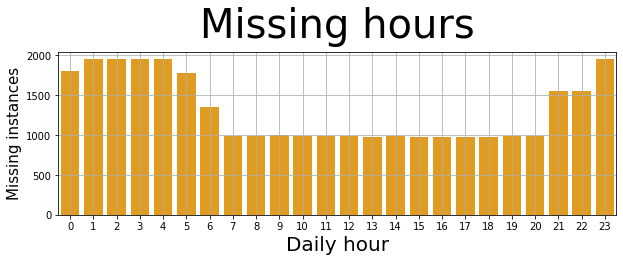

--> Filled the (inverter) missing values.
--> Observations with missing values (77948) have been dropped.

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 46679
INVERTER DF: 14574
--> Columns (4): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C)
--> Missing inverter data: 32105 (68.78 %)


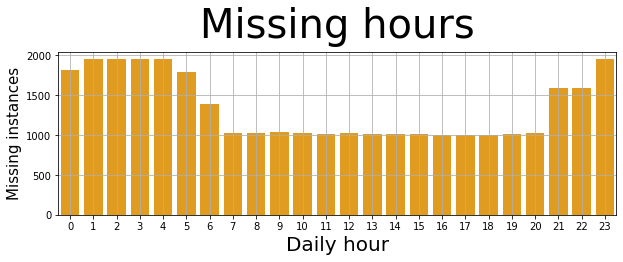

--> Filled the (inverter) missing values.
--> Observations with missing values (77948) have been dropped.


In [115]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Retrieve the main dataset
    df = inv_stringBoxes_data[inv_name]
    print("ALARMS DF:", len(df))
    
    # Retrieve the inverter data
    inv_df = inv_data[inv_name]
    inv_df.index = inv_df['Date/Time']
    
    # Select only the relevant columns concerning the inverter
    inv_df = inv_df[selected_inv_columns]
    print("INVERTER DF:", len(inv_df))
    print(f"--> Columns ({len(selected_inv_columns)}):", ', '.join(selected_inv_columns))
    
    # Merge the data
    merged_df = inv_df.merge(df, how = 'right', left_index = True, right_index = True)
 
    # Chech the NaN values
    empty_ts = set(merged_df[merged_df.isnull().values].index)
    empty_hours = np.array(sorted(Counter(item.strftime('%H') for item in empty_ts).most_common(), key = lambda item: item[0]))
    print(f"--> Missing inverter data: {len(empty_ts)} ({(round((len(empty_ts)/len(merged_df))* 100, 2))} %)")

    plt.figure(figsize = (10, 3))
    sns.barplot(x = [int(hour) for hour in empty_hours[:, 0]], y =  [int(counter) for counter in empty_hours[:, 1]], 
                color = 'orange')
    plt.title("Missing hours", fontsize = 40, y = 1.05)
    plt.xlabel('Daily hour', fontsize = 20)
    plt.ylabel('Missing instances', fontsize = 15)
    plt.grid()
    plt.show()
    
    # CASE 1: Fille nan values
    if fill_nan_values:
        merged_df.loc[:, 'Cc 1 (A)'].fillna(method = 'ffill', inplace = True) 
        merged_df.loc[:, 'Vcc 1 (V)'].fillna(method = 'ffill',  inplace = True)
        merged_df.loc[:, 'Irradiance (W/mq)'].fillna(method = 'ffill', inplace = True)
        merged_df.loc[:, 'Amb. Temp (°C)'].fillna(method = 'ffill', inplace = True)
        print("--> Filled the (inverter) missing values.")
    
    # Drop observations that was not filled 
    print(f"--> Observations with missing values ({len(merged_df[merged_df.isnull().values])}) have been dropped.")
    merged_df.dropna(inplace = True)

    # Assign the merged_df to its inverter
    inv_stringBoxes_data[inv_name] = merged_df
    
    #display(merged_df)

## 3.5) Create features for each pair of class and stringbox

In [116]:
class_prefix = 'CLASS'

In [117]:
for inv_name in inv_names:
    print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Retrieve the dataset
    df = inv_stringBoxes_data[inv_name]
    #display(df)
    
    # The different cases
    class_col = 'Labels'
    stringBox_cols = [col for col in df.columns 
                      if (col not in selected_inv_columns) and (col != class_col)]
    freq_cols = [col for col in df.columns if 'faulty_strings' in col] 
    
    # Split the data
    partial_dfs = []
    
    # A) Split the labels (i.e., outputs)
    partial_dfs.append(pd.DataFrame(
            data = df[class_col].tolist(), 
            columns = [f'{class_prefix} {ascii_uppercase[idk]}: {class_name}' 
                       for idk, class_name in enumerate(output_classes)], 
            index = df.index
        ))
    
    # Inverter features
    partial_dfs.append(df[selected_inv_columns])
    
    # B) Split the string box data
    for col in stringBox_cols:
        if 'faulty_strings' in col:
            df_data = df[col].apply(lambda arr: arr[:, 0]).tolist()
        else:
            df_data = df[col].tolist()
            
        partial_dfs.append(pd.DataFrame(
            data = df_data, 
            columns = [f'{col}: {class_name}' for class_name in input_classes], 
            index = df.index
        ))
        
    # C) Attach the columns relate to the frequencies
    #partial_dfs.append(df[freq_cols])
        
    # C) Build the merged dataframe
    merged_splitted_df = pd.concat(partial_dfs, axis = 1)
    
    # Save the splitted df
    inv_stringBoxes_data[inv_name] = merged_splitted_df
    print("\t\t\t\t\t\t OK\n")
    #display(merged_splitted_df)

#print("COLUMNS:\n--> " + '\n--> '.join(inv_stringBoxes_data[inv_name].columns))

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

						 OK

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

						 OK



## 3.6) Remove reduntant features (i.e., unnecessary pairs)

In [118]:
remove_redundant_features = True

In [119]:
redundant_pairs = {
    'Corrente di stringa fuori range': r"^QC\d$", # QCX
    'String-box con produzione anomala': r"QC\d_.*" # QCX_sY
}

In [120]:
if remove_redundant_features:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the dataset
        df = inv_stringBoxes_data[inv_name]
        
        #display(df.iloc[0])
        cols_to_remove = df.columns.tolist()
        print("TOTAL COLUMNS:", len(cols_to_remove))

        # Remove the output columns from the columns having all zero values
        [cols_to_remove.remove(col_name) for col_name in cols_to_remove.copy() if class_prefix in col_name]
        
        # Remove the inverter data
        [cols_to_remove.remove(col_name) for col_name in cols_to_remove.copy() if col_name in selected_inv_columns]
        
        # Remove the columns related to the frequency
        #[cols_to_remove.remove(col_name) for col_name in cols_to_remove.copy() if 'faulty_strings' in col_name]
        
        # Select only the unnecessary features (i.e., pairs_to_remove)
        for full_col_name in cols_to_remove.copy():
            component_prefix, alarm = [item.strip() for item in full_col_name.split(':')]

            if alarm in redundant_pairs.keys():
                regex_prefix_to_check = redundant_pairs[alarm]
  
                # Select only features matching the prefix to discard 
                if not match(regex_prefix_to_check, component_prefix):
                    cols_to_remove.remove(full_col_name)
            else:
                # Select only features that is considered as pairs (i.e., pairs_to_remove)
                cols_to_remove.remove(full_col_name)

        # Remove the columns 
        if len(cols_to_remove) > 0:
            print(f"--> Removed {len(cols_to_remove)} columns that were unnecessary!\n"\
                  f"CURRENT FEATURES: from {len(df.columns)} to {len(df.columns) - len(cols_to_remove)}\n")
            print(cols_to_remove)
            df.drop(columns = cols_to_remove, inplace = True)
        else:
            print("There are no unnecessary columns!\n")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TOTAL COLUMNS: 24
--> Removed 6 columns that were unnecessary!
CURRENT FEATURES: from 24 to 18

['QC1: Corrente di stringa fuori range', 'QC2: Corrente di stringa fuori range', 'QC3: Corrente di stringa fuori range', 'QC4: Corrente di stringa fuori range', 'QC5: Corrente di stringa fuori range', 'QC6: Corrente di stringa fuori range']
--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

T

## Fill the empty timestamps

In [121]:
fill_empty_ts = True

In [122]:
if fill_empty_ts:
    for inv_name in inv_names:  
        print("-" * 40, inv_name, "-" * 40)
        
        inv_stringBoxes_data[inv_name] = lstm_utils.fill_empty_ts(inv_stringBoxes_data[inv_name])
        inv_stringBoxes_data[inv_name].info()

---------------------------------------- INV1 ----------------------------------------
Missing timestamps 0 out of 27192
--> SO: The dataframe has been filled with 0 (0.0 %) missing timestamps.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27192 entries, 2018-08-08 11:00:00 to 2021-09-14 10:00:00
Freq: H
Data columns (total 18 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   CLASS A: Isolamento                                  27192 non-null  int64  
 1   CLASS B: String-box con corrente a 0                 27192 non-null  int64  
 2   Cc 1 (A)                                             27192 non-null  float64
 3   Vcc 1 (V)                                            27192 non-null  float64
 4   Irradiance (W/mq)                                    27192 non-null  float64
 5   Amb. Temp (°C)                                       27192 non-null  float

## Merge all the inverter data 

In [123]:
merge_inverter_data = False

In [124]:
verbose = True
dict_name = 'All inverters'
inv_timestamps = dict()

# BETTER APPROACH: MultiIndex (inv, ts) --> attenzione per la generazione delle finestre temporali

if merge_inverter_data:
    num_inv_within_data = len(inv_names)
    
    # Shift the timestamps & compute the train and test splits
    all_df = []
    
    for inv_idk, inv_name in enumerate(inv_names):
        df = inv_stringBoxes_data[inv_name]
        display(df.iloc[0, [0, 1, 2, 3, 5, 6, 7, 8]].to_frame().transpose())
        
        # Shift the timestamps of the inverter 
        print(f"\n{inv_name}: \n--> EXAMPLE (PRE): ", df.index[0])
        if inv_idk < 3: # Avoid numerical overflow (with a temporal shift of 300 years)
            temporal_shift = 365 * 100 * inv_idk
            print(f"--> Adding {temporal_shift // 365} years")
            df.index += pd.Timedelta(temporal_shift, unit = 'days')
        else:
            temporal_shift = 365 * 100 * 1
            print(f"--> Subtracting {temporal_shift // 365} years")
            df.index -= pd.Timedelta(temporal_shift, unit = 'days')
        print(f"--> EXAMPLE (POST): ", df.index[0])
        all_df.append(df)
            
        # Train/Split 
        test_size = 0.3
        train_ts, test_ts = train_test_split(df.index, test_size = test_size, shuffle = True, random_state = 101)
        inv_timestamps[inv_name] = {'train': train_ts, 'test': test_ts}
        print(f"[{inv_name}] TRAIN: {len(train_ts)} obs. --- TEST: {len(test_ts)} obs.")
        
    # Merge the shifed datasets of the inverters
    merged_df = pd.concat(all_df).sort_index()
    print(f"\nInverter data (i.e., {', '.join(inv_names)}) has been merged. "\
          f"The dataset has now {len(merged_df)} observations.")
        
    if verbose:
        print("\n" + "-" * 58, "EXAMPLE", "-" * 58)
        merged_df.info()

    # Save the data
    inv_stringBoxes_data.clear()
    inv_stringBoxes_data[dict_name] = merged_df
    original_inv_names = inv_names
    inv_names = [dict_name] 
else:
    num_inv_within_data = 1
    original_inv_names = inv_names

## 3.7) Generate the train/test split

In [125]:
train_timestamps = dict()
test_timestamps = dict()

In [126]:
test_size = 0.3

In [127]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Get the data
    df = inv_stringBoxes_data[inv_name]
    display(df)
    output_cols = [col for col in df.columns if class_prefix in col]
   
    # Split the timestamps into train/test
    if not merge_inverter_data:
        train_ts, test_ts = train_test_split(df.index.tolist(), test_size = test_size, shuffle = True, random_state = 101)
        
    # Retrive the splitted timestamps
    else:
        train_ts, test_ts = [], []
        for inverter_name, inv_ts in inv_timestamps.items():
            train_ts.extend(inv_ts['train'])
            test_ts.extend(inv_ts['test'])
            
    train_timestamps[inv_name] = sorted(train_ts)
    test_timestamps[inv_name] = sorted(test_ts)
    
    print(f"TRAIN SET ({int((1- test_size)*100)} %): {len(train_ts)} obs. \n" + "-" * 50)
    display(df.loc[train_ts, output_cols].sum())
    #display(df.loc[train_timestamps[inv_name][0], :])
        
    print(f"TEST SET ({int(test_size * 100)} %):  {len(test_ts)} obs. \n" + "-" * 50)
    display(df.loc[test_ts, output_cols].sum())


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



,CLASS A: Isolamento,CLASS B: String-box con corrente a 0,Cc 1 (A),Vcc 1 (V),Irradiance (W/mq),Amb. Temp (°C),QC1_strings_time: Corrente di stringa fuori range,QC2_strings_time: Corrente di stringa fuori range,QC3_strings_time: Corrente di stringa fuori range,QC4_strings_time: Corrente di stringa fuori range,QC5_strings_time: Corrente di stringa fuori range,QC6_strings_time: Corrente di stringa fuori range,QC1_faulty_strings: Corrente di stringa fuori range,QC2_faulty_strings: Corrente di stringa fuori range,QC3_faulty_strings: Corrente di stringa fuori range,QC4_faulty_strings: Corrente di stringa fuori range,QC5_faulty_strings: Corrente di stringa fuori range,QC6_faulty_strings: Corrente di stringa fuori range
2018-08-08 11:00:00,0,0,384.0,393.0,1243.0,35.80,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0
2018-08-08 12:00:00,0,0,411.0,389.0,1056.0,35.72,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0
2018-08-08 13:00:00,0,0,439.0,387.0,1054.0,36.34,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0
2018-08-08 14:00:00,0,0,451.0,380.0,1066.0,35.34,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0
2018-08-08 15:00:00,0,0,286.0,404.0,977.0,33.35,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-14 06:00:00,0,1,0.0,22.0,14.0,27.03,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0
2021-09-14 07:00:00,0,1,0.0,22.0,14.0,27.03,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0
2021-09-14 08:00:00,0,1,0.0,22.0,14.0,27.03,10,0,0,0,0,0,0.0833,0.0,0.0,0.0,0.0,0.0
2021-09-14 09:00:00,0,1,0.0,22.0,14.0,27.03,35,0,0,0,0,0,0.0833,0.0,0.0,0.0,0.0,0.0


TRAIN SET (70 %): 19034 obs. 
--------------------------------------------------


CLASS A: Isolamento                        4
CLASS B: String-box con corrente a 0    7311
dtype: int64

TEST SET (30 %):  8158 obs. 
--------------------------------------------------


CLASS A: Isolamento                        2
CLASS B: String-box con corrente a 0    3152
dtype: int64


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



,CLASS A: Isolamento,CLASS B: String-box con corrente a 0,Cc 1 (A),Vcc 1 (V),Irradiance (W/mq),Amb. Temp (°C),QC1_strings_time: Corrente di stringa fuori range,QC2_strings_time: Corrente di stringa fuori range,QC3_strings_time: Corrente di stringa fuori range,QC4_strings_time: Corrente di stringa fuori range,QC5_strings_time: Corrente di stringa fuori range,QC6_strings_time: Corrente di stringa fuori range,QC1_faulty_strings: Corrente di stringa fuori range,QC2_faulty_strings: Corrente di stringa fuori range,QC3_faulty_strings: Corrente di stringa fuori range,QC4_faulty_strings: Corrente di stringa fuori range,QC5_faulty_strings: Corrente di stringa fuori range,QC6_faulty_strings: Corrente di stringa fuori range
2018-08-08 11:00:00,0,0,354.0,405.0,1243.0,35.80,0,0,0,0,240,0,0.0,0.0,0.0,0.0,0.4,0.0
2018-08-08 12:00:00,0,0,387.0,393.0,1056.0,35.72,0,0,0,0,240,0,0.0,0.0,0.0,0.0,0.4,0.0
2018-08-08 13:00:00,0,0,418.0,389.0,1054.0,36.34,0,0,0,0,240,0,0.0,0.0,0.0,0.0,0.4,0.0
2018-08-08 14:00:00,0,0,422.0,390.0,1066.0,35.34,0,0,0,0,160,0,0.0,0.0,0.0,0.0,0.4,0.0
2018-08-08 15:00:00,0,0,266.0,405.0,977.0,33.35,0,0,0,0,28,0,0.0,0.0,0.0,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-14 06:00:00,0,0,323.0,401.0,633.0,36.38,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-14 07:00:00,0,0,323.0,401.0,633.0,36.38,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-14 08:00:00,0,0,323.0,401.0,633.0,36.38,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-14 09:00:00,0,0,323.0,401.0,633.0,36.38,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


TRAIN SET (70 %): 19034 obs. 
--------------------------------------------------


CLASS A: Isolamento                        0
CLASS B: String-box con corrente a 0    5532
dtype: int64

TEST SET (30 %):  8158 obs. 
--------------------------------------------------


CLASS A: Isolamento                        0
CLASS B: String-box con corrente a 0    2349
dtype: int64

## 3.8) Standard scaler

In [128]:
standardize_input_data = True

In [129]:
data_std_scalers = dict()
if standardize_input_data:
    for inv_name in inv_names:
        print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110)
        
        # Retrieve the data
        df = inv_stringBoxes_data[inv_name]
        train_ts = train_timestamps[inv_name]
        
        # Select only the columns concerning the input features
        cols_to_strandardized = [col_name for col_name in df.columns 
                                 if (class_prefix not in col_name) and ('faulty_strings'not in col_name)]
                
        skipped_cols = sorted(set(df.columns) - set(cols_to_strandardized))
        print(f"Skipped the following ({len(skipped_cols)}) columns:\n--> " + '\n--> '.join(skipped_cols))
        
        # Fit and save the standardScaler
        scaler = StandardScaler().fit(df.loc[train_ts, cols_to_strandardized])
        data_std_scalers[inv_name] = scaler
        
        df.loc[:, cols_to_strandardized] = pd.DataFrame(data = scaler.transform(df[cols_to_strandardized]),
                                                        index = df.index, 
                                                        columns = cols_to_strandardized)
        print("\n\t\t\t\t OK: Data has been standardized.\n")
else:
    print("This pre-processing step (Data standardization) has not been selected.")


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
Skipped the following (8) columns:
--> CLASS A: Isolamento
--> CLASS B: String-box con corrente a 0
--> QC1_faulty_strings: Corrente di stringa fuori range
--> QC2_faulty_strings: Corrente di stringa fuori range
--> QC3_faulty_strings: Corrente di stringa fuori range
--> QC4_faulty_strings: Corrente di stringa fuori range
--> QC5_faulty_strings: Corrente di stringa fuori range
--> QC6_faulty_strings: Corrente di stringa fuori range

				 OK: Data has been standardized.


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 ---------------------------

In [130]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, system_name, ":", inv_name, "-" * 50 + "\n" + "-" * 110)
        
    scaler = data_std_scalers[inv_name]
    
    file_path = path.join(main_folder_path, 'Params', f'{inv_name}_stdScaler_generalizedApproch.txt')
    
    with open(file_path, 'w') as txt_file:
        txt_file.write(f"\n[Standard Scaler] [{inv_name}]\n")
        txt_file.write("FEATURES:\n" + ','.join(scaler.feature_names_in_)+ "\n")
        txt_file.write("MEAN:\n" + ','.join([str(value) for value in scaler.mean_]) + "\n")
        txt_file.write("VARIANCE:\n" + ','.join([str(value) for value in scaler.var_]) + "\n")
        
        print(f"[{inv_name}] The paramaters (i.e., mean and variance) of the standard scaler have been saved. ")  


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- Soleto 2 : INV1 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
[INV1] The paramaters (i.e., mean and variance) of the standard scaler have been saved. 

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- Soleto 2 : INV2 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
[INV2] The paramaters (i.e., mean and variance) of the standard scaler have been saved. 


## Data exploration
### Feature selection

In [131]:
visualize_exploration = True

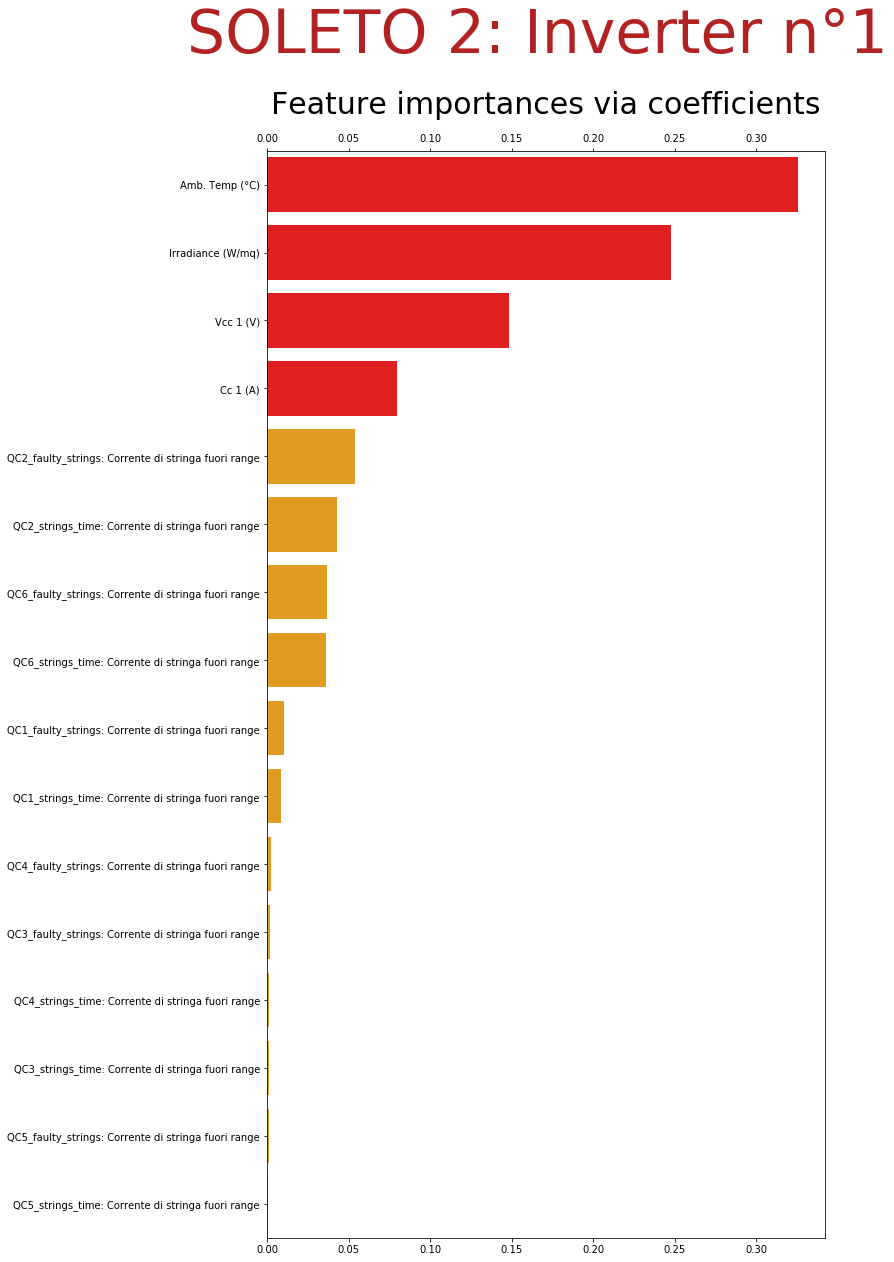

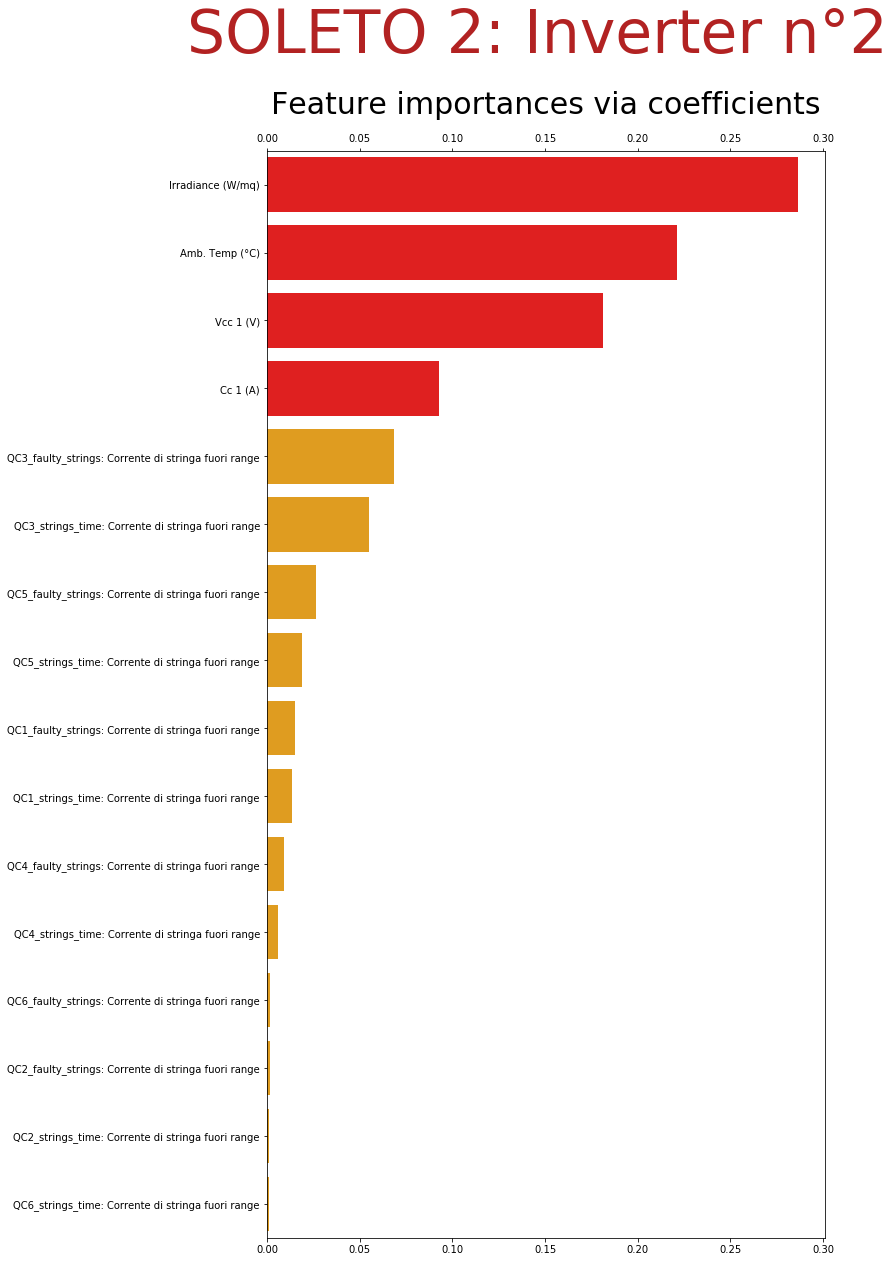

In [132]:
if visualize_exploration:
    for inv_name in inv_names:
        
        # Retrieve the data
        df = inv_stringBoxes_data[inv_name]

        output_cols = [col for col in df.columns if class_prefix in col]
        inputs_cols = np.array([col for col in df.columns if col not in output_cols])

        # Input data
        inputs = df[inputs_cols]
        outputs = df[output_cols]

        # Tree
        clf = ExtraTreesClassifier(n_estimators = 500, random_state = 101)
        clf.fit(inputs, outputs)

        # Get the coef.
        importance = list(zip(inputs_cols, clf.feature_importances_))
        importance = sorted(importance, key = lambda item: item[1], reverse = True)

        # Visulize
        fig, axes = plt.subplots(figsize = (10, 20),  facecolor = "white")
        fig.suptitle(f"{system_name.upper()}: Inverter n°{inv_name[-1]}", fontsize = 60, color = 'firebrick')
        sns.barplot(x = [item[1] for item in importance], 
                    y = [item[0] for item in importance], 
                    palette = ['red' if feature_name in selected_inv_columns else 'orange' for feature_name, _ in importance],
                    ax = axes)
        axes.set_title("Feature importances via coefficients", pad = 20, size = 30)
        axes.tick_params(axis = 'x', top = True, labeltop = True)
        plt.show()

## 3.9) [END] Data preparation

In [133]:
inv_idk  = 0

In [134]:
inv_name = inv_names[inv_idk]
df = inv_stringBoxes_data[inv_name]

train_ts = train_timestamps[inv_name]
test_ts = test_timestamps[inv_name]

print("-" * 110 + "\n" + "-" * 50, "TRAIN:", inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
df.loc[train_ts, :].info()
#display(df.loc[train_ts, :].iloc[:50])

print("-" * 110 + "\n" + "-" * 50, "TEST:", inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
df.loc[test_ts, :].info()
#display(df.loc[test_ts, :].iloc[:50])

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- TRAIN: INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19034 entries, 2018-08-08 11:00:00 to 2021-09-14 10:00:00
Data columns (total 18 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   CLASS A: Isolamento                                  19034 non-null  int64  
 1   CLASS B: String-box con corrente a 0                 19034 non-null  int64  
 2   Cc 1 (A)                                             19034 non-null  float64
 3   Vcc 1 (V)                                            19034 non-null  float64
 4   Irradiance (W/mq)    

# Logistic LSTM 

In [135]:
grid_search = False
#grid_search = True

In [136]:
pre_trained = True
#pre_trained = False

## Fixed parameters

In [137]:
num_epochs = 100
batch_size = 16 * num_inv_within_data

In [138]:
enconding_one_obs = True

## Create the saving folders

In [139]:
trained_inv_model = dict()

In [140]:
main_saving_folder = 'UC2 - LSTM'
saving_path = path.join(system_path, "..", "..", main_saving_folder)

if not path.exists(saving_path):
    makedirs(saving_path)
    print(f"The folder '{main_saving_folder}' has been created!")

In [141]:
version = " - Generalized Version"
subfolders = ['Grid search' + version, 'Trained models' + version, 'Test metrics' + version]
for subfolder in subfolders:
    sub_saving_path = path.join(saving_path, subfolder)
    
    if not path.exists(sub_saving_path):
        makedirs(sub_saving_path)
        print(f"The sub-folder '{main_saving_folder}/{subfolder}' has been created!")

## Grid search

### The parameters

In [142]:
#window_dims = [1, 12, 24, 36, 48, 72, 96, 120, 168, 216, 264]
#neurons_values = [32, 64, 92, 128, 192, 256]

#window_dims = [12, 24]
#neurons_values = [16]

#window_dims = [12, 24, 36, 48, 72, 96, 120, 168]
#neurons_values = [16, 20, 32]

#num_hid_layers = 2
#window_dims = [12, 24, 36, 48, 72, 96, 120, 168]
#neurons_values = [20, 16, 10, 8]

num_hid_layers = 3
window_dims = [12, 24, 48, 72, 96, 120, 168, 216, 264]
neurons_values = [16, 32, 64, 92, 128, 192, 256]

### The function

In [143]:
verbose = True

In [144]:
grid_search_best_params = dict()
if grid_search and not pre_trained: 
    
    inv_best_scores = dict()
    
    for inv_name in inv_names:
        #initialize the best metrics df
        counter = 0
        df_best_metrics = pd.DataFrame()
        
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the dataset
        df = inv_stringBoxes_data[inv_name]
        train_ts = train_timestamps[inv_name]
        
        # Skip the first x hours to use the same data for each combination
        first_ts = df.index[0] + pd.Timedelta(window_dims[-1], unit = 'hours')
        df = df[first_ts:]

        # Build the train/validation splits
        output_cols = [col for col in df.columns if class_prefix in col]

        best_scores = None

        # Test the combiantion of the two hyper-parameters
        print("-" * 110 + "\n" + "-" * 50, "GRID SEARCH", "-" * 50 + "\n" + "-" * 110)
        for j, dim_window in enumerate(window_dims):
            
            # Generate the data for the temporal window
            # X: [obs, hours, features] ---------- Y: [obs, classes]
            print(f"--> Generating the data sequences (temporal window: {dim_window} hours)\n")
            x_values, y_values, x_feature_names, timestamps = lstm_utils.generate_data_sequences(df, output_cols, dim_window, 
                                                                                                 enconding_one_obs, verbose)
            
            # Isolate only the rows concerning training observations
            train_idks = np.argwhere(np.isin(timestamps, train_ts)).flatten()
            train_x_values = x_values[train_idks]
            train_y_values = y_values[train_idks]
            
            # Perform the train/validation split
            valid_dim = 0.2
            x_train, x_valid, y_train, y_valid = train_test_split(train_x_values, train_y_values, test_size = valid_dim, 
                                                                  shuffle = True, random_state = 101)
            num_input_features = x_train.shape[-1]
            num_output_classes = y_train.shape[-1]
            
            for i, starting_num_neurons in enumerate(neurons_values):
                print("\n" + "-" * 40)
                print(f"({i + 1}/{len(neurons_values)}) Starting neurons:", starting_num_neurons)
                print(f"({j + 1}/{len(window_dims)}) Temporal window:", dim_window, "hours")
                print("-" * 40, "\n")
                print("INPUT DATA:", x_values.shape)
                print("--> [TRAIN] INPUT DATA:", x_train.shape)
                #display(x_train[0, -1, :])
                print("--> [VALID] INPUT DATA: ", x_valid.shape)
                print("\nOUTPUT DATA:", y_values.shape)
                print("--> [TRAIN] OUTPUT DATA:", y_train.shape)
                print("\t--> AVAILABLE CLASSES:", np.sum(y_train, axis = 0))
                #display(y_train[0])
                print("--> [VALID] OUTPUT DATA: ", y_valid.shape)
                print("\t-->  AVAILABLE CLASSES:", np.sum(y_valid, axis = 0), "\n")
                
                # Initialize the LSTM network
                lstm_model = lstm_utils.initialize_lstm(starting_num_neurons, dim_window, num_input_features, 
                                                        num_output_classes, enconding_one_obs, num_hid_layers = num_hid_layers)

                # Train the LSTM 
                history, best_config_perfomances = lstm_utils.train_model(lstm_model, (x_train, y_train), (x_valid, y_valid), 
                                                                          num_epochs, batch_size, shuffle_flag = True, 
                                                                          visualize_graph = True)
                
                best_config_perfomances['Starting neurons'] = starting_num_neurons
                best_config_perfomances['Window dimensions'] = dim_window

                # Save the perfomance of this configuration in a log file
                log_file_name = f'lstm_gridSearch_perfomance_{inv_name}_hid_layers_{num_hid_layers}' + ".txt"
                with open(path.join(saving_path, subfolders[0], log_file_name), 'a') as log_file:
                    for key, value in best_config_perfomances.items():
                        if isinstance(value, float) or isinstance(value, np.int64):
                            value = np.round(value, 4)
                        log_file.write(f'{key.upper()}: {value}\n')
                        
                    log_file.write("-" * 50 + "\n")
                for key, value in best_config_perfomances.items():
                    if isinstance(value, float) or isinstance(value, np.int64):
                        value = np.round(value, 4)
                    #update the metrics df
                    df_best_metrics.loc[counter,key] = value
                counter = counter + 1

                # Monitor perfomance (i.e., compare the perfomance with the best one recorded)
                metrics_to_monitor = 'Val ' + 'f1 score'  # "loss", "binary accuracy", "precision"
                if (not best_scores) or (best_config_perfomances[metrics_to_monitor] > best_scores[metrics_to_monitor]):

                    # Save the perfomance
                    best_scores = best_config_perfomances

                    # Save the trained model 
                    trained_inv_model[inv_name] = lstm_model
                else:
                    print("It's not the best!. Delta from the best: "\
                          f"{best_config_perfomances[metrics_to_monitor] - best_scores[metrics_to_monitor]}")
        
        #save the df best metrics
        best_perfomance_df_name = f'lstm_gridSearch_df_perfomance_{inv_name}_hid_layers_{num_hid_layers}.csv'
        df_best_metrics.to_csv(path.join(saving_path, subfolders[0], best_perfomance_df_name))
        
        # Visualize and save the best perfomance
        print("\n"+ "-" * 110 + "\n" + "-" * 40, "FINDINGS of the GRID SEARCH", "-" * 40 + "\n" + "-" * 110, "\n")
        grid_search_best_params[inv_name] = best_scores
        
        best_perfomance_name = f'best_perfomance_{inv_name}_hid_layers_{num_hid_layers}' + ".txt"
        with open(path.join(saving_path, subfolders[0], best_perfomance_name), 'w') as log_file:
            for key, value in best_scores.items():
                if isinstance(value, float) or isinstance(value, np.int64):
                    value = np.round(value, 4)
                log_file.write(f'{key.upper()}: {value}\n')
                print(f'{key}: {value}')
                
        inv_best_scores[inv_name] = best_scores
else:
    print("This step has been skipped.")

This step has been skipped.


###### correct a little issue in saving

## Train the LSTM

### Hyperparameters

In [145]:
avg_config = True

In [146]:
system_name

'Soleto 2'

In [147]:
SYSTEM_NAMES[3]

'Soleto 2'

In [148]:
# set the model configurations for the not pretrained model (the values pre set are related to the cross validation)

if not pre_trained:
    if system_name == SYSTEM_NAMES[2]:
        if avg_config:
            params = {inv_name : {'num_neurons': 64, 'window_length' : 72} for inv_name in inv_names}
        elif merge_inverter_data: 
            params = {dict_name: {'num_neurons': 128, 'window_length': 72}}
        else:
            params = {
                'INV1': {
                    'num_neurons': 92, 
                    'window_length': 12
                },
                'INV2': {
                    'num_neurons': 32, 
                    'window_length':216
                },
                'INV4': {
                    'num_neurons': 192, 
                    'window_length': 264
                }
            }  
    elif system_name == SYSTEM_NAMES[3]:
        if avg_config:
            params = {inv_name : {'num_neurons': 64, 'window_length' : 264} for inv_name in inv_names}
#            params = {inv_name : {'num_neurons': 256, 'window_length' : 120} for inv_name in inv_names}
        elif merge_inverter_data: 
            params = {dict_name: {'num_neurons': 0, 'window_length': 0}}
        else:
            params = {
                'INV1': {
                    'num_neurons': 64, 
                    'window_length': 96, 
                },
                'INV2': {
                    'num_neurons': 92, 
                    'window_length':216,
                }
            }
    elif system_name == SYSTEM_NAMES[4]:
        if avg_config:
            params = {inv_name : {'num_neurons': 256, 'window_length' : 72} for inv_name in inv_names}
        elif merge_inverter_data: 
            params = {dict_name: {'num_neurons': 256, 'window_length': 168}}
        else:
            params = {
                'INV1': {
                    'num_neurons': 128, 
                    'window_length':72,
                },
                'INV2': {
                    'num_neurons': 128, 
                    'window_length':96,
                },
                'INV3': {
                    'num_neurons':92, 
                    'window_length':216,
                },
                'INV4': {
                    'num_neurons':92, 
                    'window_length':72,
                }
        }
    print("-" * 12, f"PV System: {system_name}", "-" * 12)
    print("--> "+ '\n--> '.join([f"{inv_name}: {config['num_neurons']} starting neurons with {config['window_length']} hours" 
                                 for inv_name, config in params.items()]))

### Carry out the train stage for each inverter 

In [149]:
if not grid_search and not pre_trained:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the inverter dataset
        df = inv_stringBoxes_data[inv_name]
        train_ts = train_timestamps[inv_name]
        print("ALL DATA:", len(df))
        
        # Skip the first x hours to use the same data for each combination
        first_ts = df.index[0] + pd.Timedelta(window_dims[-1], unit = 'hours')
        df = df[first_ts:]
        
        # Build the train/validation splits
        output_cols = [col for col in df.columns if class_prefix in col]

        # Retrieve the inverter parameters
        num_neurons = params[inv_name]['num_neurons']
        window_length = params[inv_name]['window_length']
        
        # Generate the data for the temporal window
        print(f"--> Generating the data sequences (temporal window: {window_length} hours)\n")
        x_values, y_values, x_feature_names, timestamps = lstm_utils.generate_data_sequences(df, output_cols, window_length, 
                                                                                             enconding_one_obs, verbose)
        print("X VALUES:", x_values.shape)
        print("Y VALUES:", y_values.shape)
        
        # Isolate only the rows concerning training observations
        train_idks = np.argwhere(np.isin(timestamps, train_ts)).flatten()
        train_x_values = x_values[train_idks]
        train_y_values = y_values[train_idks]
        display(train_x_values)

        # Perform the train/validation split
        valid_dim = 0.2
        x_train, x_valid, y_train, y_valid = train_test_split(train_x_values, train_y_values, test_size = valid_dim, 
                                                              shuffle = True, random_state = 101)
        print("-" * 40)
        print("INPUT DATA:", x_values.shape)
        print("--> [TRAIN] INPUT DATA:", x_train.shape)
        print("--> [VALID] INPUT DATA: ", x_valid.shape)
        print("\nOUTPUT DATA:", y_values.shape)
        print("--> [TRAIN] OUTPUT DATA:", y_train.shape)
        print("--> [VALID] OUTPUT DATA: ", y_valid.shape)
        print("-" * 40, "\n")
    
        num_input_features = x_train.shape[-1]
        num_output_classes = y_train.shape[-1]

        # Initialize the LSTM
        lstm_model = lstm_utils.initialize_lstm(num_neurons, window_length, num_input_features,  num_output_classes, 
                                                enconding_one_obs)

        # Train the LSTM 
        graph_file_path = path.join(saving_path, subfolders[1], 
                                    f'{inv_name}_{num_neurons}N{window_length}h_modelPerfomance.png')
        history, best_perfomances = lstm_utils.train_model(lstm_model, (x_train, y_train), (x_valid, y_valid), num_epochs, 
                                                           batch_size, shuffle_flag = True, visualize_graph = True, 
                                                           saving_graph_path = graph_file_path)
        # Save the trained LSTM
        trained_inv_model[inv_name] = lstm_model
else:
    print("This step has been skipped.")

This step has been skipped.


## Save the trained models

In [150]:
if not pre_trained:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
        
        trained_lstm = trained_inv_model[inv_name]

        # Save the best model
        file_name = f'{inv_name}_trained_model'
        
        if grid_search: 
            file_name += '_' + str(grid_search_best_params[inv_name]['Starting neurons']) + 'N' 
            file_name += '_' + str(grid_search_best_params[inv_name]['Window dimensions']) + "H"
        else: 
            file_name += '_' + str(params[inv_name]['num_neurons']) + 'N_' + str(params[inv_name]['window_length']) + "H"
            
        file_path = path.join(saving_path, subfolders[1], file_name)
        trained_lstm.save(file_path)
else:
    print("This step has been skipped.")

This step has been skipped.


## Load the trained models

In [151]:
if pre_trained:
    if system_name == SYSTEM_NAMES[2]:
        if avg_config:
            config_to_load = {inv_name : {'num_neurons': 64, 'window_length' : 72} for inv_name in inv_names}

        elif merge_inverter_data: 
            config_to_load = {dict_name: {'num_neurons': 128, 'window_length': 72}}
        else:
            config_to_load = {
                'INV1': {
                    'num_neurons': 92, 
                    'window_length': 12
                },
                'INV2': {
                    'num_neurons': 32, 
                    'window_length':216
                },
                'INV4': {
                    'num_neurons': 192, 
                    'window_length': 264
                }
            }
    elif system_name == SYSTEM_NAMES[3]:
        if avg_config:
            config_to_load = {inv_name : {'num_neurons': 64, 'window_length' : 264} for inv_name in inv_names}
#            config_to_load = {inv_name : {'num_neurons': 256, 'window_length' : 120} for inv_name in inv_names}

        elif merge_inverter_data: 
            config_to_load = {dict_name: {'num_neurons': 64, 'window_length': 48}}
        else:
            config_to_load = {
                'INV1': {
                    'num_neurons': 32, 
                    'window_length': 168, 
                },
                'INV2': {
                    'num_neurons': 256, 
                    'window_length':120,
                }
            }
    elif system_name == SYSTEM_NAMES[4]:
        if avg_config:
            config_to_load = {inv_name : {'num_neurons': 256, 'window_length' : 72} for inv_name in inv_names}
        elif merge_inverter_data: 
            config_to_load = {dict_name: {'num_neurons': 256, 'window_length': 168}}
        else:
            config_to_load = {
                'INV1': {
                    'num_neurons': 128, 
                    'window_length':72,
                },
                'INV2': {
                    'num_neurons': 128, 
                    'window_length':96,
                },
                'INV3': {
                    'num_neurons':92, 
                    'window_length':216,
                },
                'INV4': {
                    'num_neurons':92, 
                    'window_length':72,
                }
        }
    print("-" * 12, f"PV System: {system_name}", "-" * 12)
    print("--> "+ '\n--> '.join([f"{inv_name}: {config['num_neurons']} starting neurons with {config['window_length']} hours" 
                                 for inv_name, config in config_to_load.items()]))

------------ PV System: Soleto 2 ------------
--> INV1: 64 starting neurons with 264 hours
--> INV2: 64 starting neurons with 264 hours


In [152]:
if pre_trained:
    for inv_name in original_inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
        
        if merge_inverter_data:
            model_name = dict_name
        else:
            model_name = inv_name

        # Load the model
        file_name = f'{model_name}_trained_model'
        
        if model_name in config_to_load.keys():
            file_name += "_" + str(config_to_load[model_name]["num_neurons"]) + "N"
            file_name += "_" + str(config_to_load[model_name]["window_length"]) + "H"
           
            file_path = path.join(saving_path, subfolders[1], file_name)
            if not path.exists(file_path):
                print(f'[{inv_name}] A trained model is not available\n')
                continue
                
            loaded_inv_model = load_model(file_path)
            loaded_inv_model.summary()

            # Save the loaded model for each inverter
            trained_inv_model[inv_name] = loaded_inv_model

            print(f"\n\t\t\t\tThe trained LSTM model (i.e., {model_name}) has been loaded.\n")
        else:
            print(f'[{inv_name}] Hey: a trained model is not available\n')
else:
    for inv_name in original_inv_names:
        if merge_inverter_data:
            trained_inv_model[inv_name] = trained_inv_model[dict_name]
            del trained_inv_model[dict_name]

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_in (LSTM)               (None, 264, 64)           20736     
_________________________________________________________________
lstm_inner1 (LSTM)           (None, 264, 32)           12416     
_________________________________________________________________
lstm_out (LSTM)              (None, 16)                3136      
_________________________________________________________________
output_layer (Dense)         (None, 2)                 34        
Total params: 36,322
Trainable params: 36,322
Non-trainable p

## Predict the classes (i.e., allarms)

In [153]:
prob_threshold = 0.5

In [154]:
verbose = True

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TEST SET:  8076 obs. 
--------------------------------------------------


CLASS A: Isolamento                        2
CLASS B: String-box con corrente a 0    3152
dtype: int64

--> Generating the data sequences (temporal window: 264 hours)


			--------------------------------------------------------------------------------
				CLASS A: Isolamento (HOURLY EVENTS: 2)
			--------------------------------------------------------------------------------


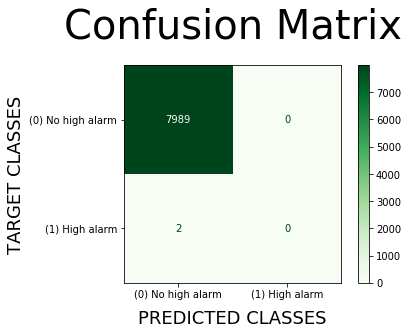

		     TN:  7989 || FP: 0 
		     FN: 2 || TP:  0


---------- CLASS METRICS ----------
ACCURACY:  99.97 %
PRECISION: 0.0 %
RECALL:    0.0 %
F1-SCORE:  0.0 %
MISCLASSIFICATION RATIO: 0.03 %

			--------------------------------------------------------------------------------
				CLASS B: String-box con corrente a 0 (HOURLY EVENTS: 3152)
			--------------------------------------------------------------------------------


/home/vieri/anaconda3/envs/SAMPLE_tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


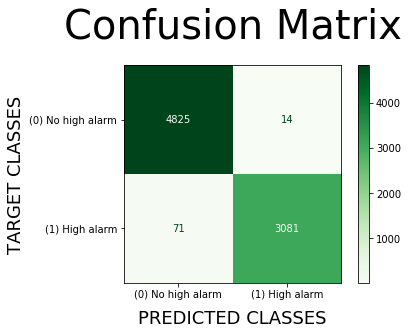

		     TN:  4825 || FP: 14 
		     FN: 71 || TP:  3081


---------- CLASS METRICS ----------
ACCURACY:  98.94 %
PRECISION: 99.55 %
RECALL:    97.75 %
F1-SCORE:  98.64 %
MISCLASSIFICATION RATIO: 1.06 %

---------------------------------------- INV1: METRICS ----------------------------------------


,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Isolamento,0.00,0.00,0.00,99.97,0.03,2
CLASS B: String-box con corrente a 0,98.64,97.75,99.55,98.94,1.06,3152


,F1 score,Recall,Precision,Accuracy,Hourly events
[AVG] ALL classes,49.32,48.88,49.78,99.46,3154


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TEST SET:  8076 obs. 
--------------------------------------------------


CLASS A: Isolamento                        0
CLASS B: String-box con corrente a 0    2349
dtype: int64

--> Generating the data sequences (temporal window: 264 hours)


			--------------------------------------------------------------------------------
				CLASS A: Isolamento (HOURLY EVENTS: 0)
			--------------------------------------------------------------------------------


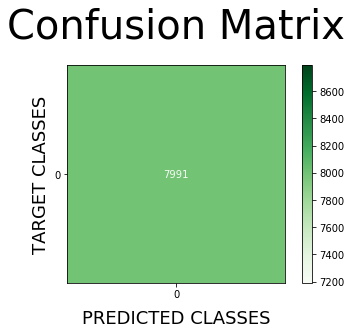


---------- CLASS METRICS ----------
ACCURACY:  100.0 %
PRECISION: nan %
RECALL:    nan %
F1-SCORE:  nan %
MISCLASSIFICATION RATIO: 0.0 %

			--------------------------------------------------------------------------------
				CLASS B: String-box con corrente a 0 (HOURLY EVENTS: 2349)
			--------------------------------------------------------------------------------


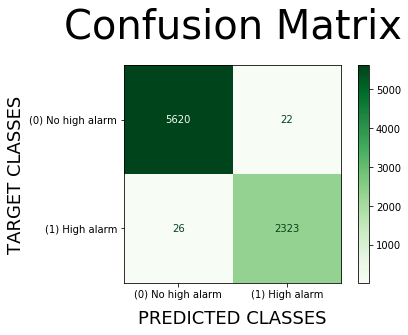

		     TN:  5620 || FP: 22 
		     FN: 26 || TP:  2323


---------- CLASS METRICS ----------
ACCURACY:  99.4 %
PRECISION: 99.06 %
RECALL:    98.89 %
F1-SCORE:  98.98 %
MISCLASSIFICATION RATIO: 0.6 %

---------------------------------------- INV2: METRICS ----------------------------------------


,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Isolamento,NaN,NaN,NaN,100.0,0.0,0
CLASS B: String-box con corrente a 0,98.98,98.89,99.06,99.4,0.6,2349


,F1 score,Recall,Precision,Accuracy,Hourly events
[AVG] ALL classes,98.98,98.89,99.06,99.7,2349


In [155]:
inv_metrics = dict()
for inv_name in trained_inv_model.keys():
    print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

    # Retrieve the dataset
    if merge_inverter_data:
        df = inv_stringBoxes_data[dict_name]
        test_ts = inv_timestamps[inv_name]['test']
        
        model_name = dict_name
    else:
        df = inv_stringBoxes_data[inv_name]
        
        # Retrieve the test timestamps 
        test_ts = test_timestamps[inv_name] 

        model_name = inv_name
    
    # Skip the first x hours to use the same data for each combination
    first_ts = df.index[0] + pd.Timedelta(window_dims[-1], unit = 'hours')
    df = df[first_ts:]
    test_ts = [ts for ts in test_ts if ts in df.index]
    
    print(f"TEST SET:  {len(test_ts)} obs. \n" + "-" * 50)
    display(df.loc[test_ts, output_cols].sum())
    
    if grid_search:
        window_length = inv_best_scores[model_name]['Window dimensions']
    elif pre_trained:
        window_length = config_to_load[model_name]['window_length']
    else:
        window_length = params[model_name]['window_length']
    
    # Retrieve the trained model
    model = trained_inv_model[inv_name]
    
    # Prepare the input data 
    print(f"--> Generating the data sequences (temporal window: {window_length} hours)\n")
    x_values, y_values, x_feature_names, timestamps = lstm_utils.generate_data_sequences(df, output_cols, window_length, 
                                                                                         enconding_one_obs, verbose)
    
    # Isolate only the rows concerning training observations
    test_idks = np.argwhere(np.isin(timestamps, test_ts)).flatten()
    test_x_values = x_values[test_idks]
    test_y_values = y_values[test_idks]
        
    # Get the output of the model
    predictions = model.predict(test_x_values, batch_size, verbose = 0)
    #display(pd.DataFrame(data = predictions, columns = output_cols).describe())
    
    # Turn the probabilities into binary classes
    predicted_classes = np.where(predictions <= prob_threshold, 0, 1)
    
    assert predicted_classes.shape == test_y_values.shape, f'DIMENSIONAL ERROR: TEST DATA: {y_classes.shape} '\
                                                       f'!= PREDICTED DATA: {predicted_classes.shape}'
    # Compute the metrics for each class
    class_metrics = lstm_utils.evaluate_predictions(predicted_classes, test_y_values, output_cols, verbose)
           
    # Save the metrics
    metrics_df = pd.DataFrame.from_dict(class_metrics, orient = 'index')
    metrics_df.iloc[:, :-1] = (metrics_df.iloc[:, :-1] * 100).round(decimals = 2)
    print("\n" + "-" * 40, inv_name + ": METRICS", "-" * 40)
    display(metrics_df)
    
    # Add a row for the avg scores
    avg_df = metrics_df.iloc[:, :-2].mean().to_frame().transpose().round(decimals = 2)
    avg_df['Hourly events'] = metrics_df['Hourly events'].sum()
    avg_df.index = ['[AVG] ALL classes']
    display(avg_df)
    
    # Visualize and save the metrics
    inv_metrics[inv_name] = metrics_df

## Overview

In [156]:
file_name = 'Metrics' + ('_AVG_configs' if avg_config else '') + ('_mergedInvData' if merge_inverter_data else '')
file_name += "_" + datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
file_path = path.join(saving_path, subfolders[2], file_name + datetime.now().strftime('%Y_%m_%d_%H_%M_%S') +'.xlsx')

writer = pd.ExcelWriter(file_path)

In [78]:
## 256N 120W
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Alarms", "-" * 50 + "\n" + "-" * 110, "\n")
list_metrics = []
for inv_name, metrics in inv_metrics.items():
    if not isinstance(metrics.index, pd.MultiIndex):
        metrics.index = pd.MultiIndex.from_tuples(tuple(zip([inv_name for j in range(len(df))], metrics.index)))
    list_metrics.append(metrics)
alarm_overall_metrics = pd.concat(list_metrics)
display(alarm_overall_metrics)

# Save as excel
alarm_overall_metrics.to_excel(writer, sheet_name = "By inverters")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- OVERVIEW: Alarms --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



F1 score  Recall  Precision  \
INV1 CLASS A: Isolamento                       0.00    0.00       0.00   
     CLASS B: String-box con corrente a 0     97.03   99.02      95.12   
INV2 CLASS A: Isolamento                        NaN     NaN        NaN   
     CLASS B: String-box con corrente a 0     99.21   99.11      99.32   

                                           Accuracy  Misclassification ratio  \
INV1 CLASS A: Isolamento                      99.98                     0.02   
     CLASS B: String-box con corrente a 0     97.62                     2.38   
INV2 CLASS A: Isolamento                     100.00                     0.00   
     CLASS B: String-box con corrente a 0     99.54                     0.46   

                                           Hourly events  
INV1 CLASS A: Isolamento                               2  
     CLASS B: String-box con corrente a 0           3152  
INV2 CLASS A: Isolamento                               0  
     CLASS B: String-box con corrente a 0           2349

In [158]:
## 64N 264W
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Alarms", "-" * 50 + "\n" + "-" * 110, "\n")
list_metrics = []
for inv_name, metrics in inv_metrics.items():
    if not isinstance(metrics.index, pd.MultiIndex):
        metrics.index = pd.MultiIndex.from_tuples(tuple(zip([inv_name for j in range(len(df))], metrics.index)))
    list_metrics.append(metrics)
alarm_overall_metrics = pd.concat(list_metrics)
display(alarm_overall_metrics)

# Save as excel
alarm_overall_metrics.to_excel(writer, sheet_name = "By inverters")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- OVERVIEW: Alarms --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



F1 score  Recall  Precision  \
INV1 CLASS A: Isolamento                       0.00    0.00       0.00   
     CLASS B: String-box con corrente a 0     98.64   97.75      99.55   
INV2 CLASS A: Isolamento                        NaN     NaN        NaN   
     CLASS B: String-box con corrente a 0     98.98   98.89      99.06   

                                           Accuracy  Misclassification ratio  \
INV1 CLASS A: Isolamento                      99.97                     0.03   
     CLASS B: String-box con corrente a 0     98.94                     1.06   
INV2 CLASS A: Isolamento                     100.00                     0.00   
     CLASS B: String-box con corrente a 0     99.40                     0.60   

                                           Hourly events  
INV1 CLASS A: Isolamento                               2  
     CLASS B: String-box con corrente a 0           3152  
INV2 CLASS A: Isolamento                               0  
     CLASS B: String-box con corrente a 0           2349

In [210]:
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Alarms", "-" * 50 + "\n" + "-" * 110, "\n")
list_metrics = []
for inv_name, metrics in inv_metrics.items():
    if not isinstance(metrics.index, pd.MultiIndex):
        metrics.index = pd.MultiIndex.from_tuples(tuple(zip([inv_name for j in range(len(df))], metrics.index)))
    list_metrics.append(metrics)
alarm_overall_metrics = pd.concat(list_metrics)
display(alarm_overall_metrics)

# Save as excel
alarm_overall_metrics.to_excel(writer, sheet_name = "By inverters")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- OVERVIEW: Alarms --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



F1 score  Recall  Precision  \
INV1 CLASS A: Isolamento                       0.00    0.00       0.00   
     CLASS B: String-box con corrente a 0     99.44   98.98      99.90   
INV2 CLASS A: Isolamento                        NaN     NaN        NaN   
     CLASS B: String-box con corrente a 0     95.34   95.32      95.36   

                                           Accuracy  Misclassification ratio  \
INV1 CLASS A: Isolamento                      99.98                     0.02   
     CLASS B: String-box con corrente a 0     99.56                     0.44   
INV2 CLASS A: Isolamento                     100.00                     0.00   
     CLASS B: String-box con corrente a 0     97.26                     2.74   

                                           Hourly events  
INV1 CLASS A: Isolamento                               2  
     CLASS B: String-box con corrente a 0           3152  
INV2 CLASS A: Isolamento                               0  
     CLASS B: String-box con corrente a 0           2349

In [123]:
#with best config pe inverter
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Alarms", "-" * 50 + "\n" + "-" * 110, "\n")
list_metrics = []
for inv_name, metrics in inv_metrics.items():
    if not isinstance(metrics.index, pd.MultiIndex):
        metrics.index = pd.MultiIndex.from_tuples(tuple(zip([inv_name for j in range(len(df))], metrics.index)))
    list_metrics.append(metrics)
alarm_overall_metrics = pd.concat(list_metrics)
display(alarm_overall_metrics)

# Save as excel
alarm_overall_metrics.to_excel(writer, sheet_name = "By inverters")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- OVERVIEW: Alarms --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



F1 score  Recall  Precision  \
INV1 CLASS A: Isolamento                       0.00    0.00       0.00   
     CLASS B: String-box con corrente a 0     99.35   98.89      99.81   
INV2 CLASS A: Isolamento                        NaN     NaN        NaN   
     CLASS B: String-box con corrente a 0     99.08   98.64      99.53   

                                           Accuracy  Misclassification ratio  \
INV1 CLASS A: Isolamento                      99.94                     0.06   
     CLASS B: String-box con corrente a 0     99.49                     0.51   
INV2 CLASS A: Isolamento                     100.00                     0.00   
     CLASS B: String-box con corrente a 0     99.46                     0.54   

                                           Hourly events  
INV1 CLASS A: Isolamento                               2  
     CLASS B: String-box con corrente a 0           3152  
INV2 CLASS A: Isolamento                               0  
     CLASS B: String-box con corrente a 0           2349

In [81]:
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Alarms", "-" * 50 + "\n" + "-" * 110, "\n")
list_metrics = []
for inv_name, metrics in inv_metrics.items():
    if not isinstance(metrics.index, pd.MultiIndex):
        metrics.index = pd.MultiIndex.from_tuples(tuple(zip([inv_name for j in range(len(df))], metrics.index)))
    list_metrics.append(metrics)
alarm_overall_metrics = pd.concat(list_metrics)
display(alarm_overall_metrics)

# Save as excel
alarm_overall_metrics.to_excel(writer, sheet_name = "By inverters")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- OVERVIEW: Alarms --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 



F1 score  Recall  Precision  \
INV1 CLASS A: Isolamento                       0.00    0.00       0.00   
     CLASS B: String-box con corrente a 0     99.14   98.79      99.49   
INV2 CLASS A: Isolamento                        NaN     NaN        NaN   
     CLASS B: String-box con corrente a 0     98.91   98.85      98.98   

                                           Accuracy  Misclassification ratio  \
INV1 CLASS A: Isolamento                      99.98                     0.02   
     CLASS B: String-box con corrente a 0     99.33                     0.67   
INV2 CLASS A: Isolamento                     100.00                     0.00   
     CLASS B: String-box con corrente a 0     99.37                     0.63   

                                           Hourly events  
INV1 CLASS A: Isolamento                               2  
     CLASS B: String-box con corrente a 0           3152  
INV2 CLASS A: Isolamento                               0  
     CLASS B: String-box con corrente a 0           2349

In [79]:
# A.2) Grouped metrics 256N 120W
alarm_overall_metrics = alarm_overall_metrics.droplevel(level = 0)
alarm_overall_metrics = alarm_overall_metrics.groupby(by = alarm_overall_metrics.index)
grouped_alarm_overall_metrics = alarm_overall_metrics.mean()
grouped_alarm_overall_metrics['Hourly events'] = alarm_overall_metrics.sum()['Hourly events']
grouped_alarm_overall_metrics = grouped_alarm_overall_metrics.round(decimals = 2)
display(grouped_alarm_overall_metrics)

# Save as excel
grouped_alarm_overall_metrics.to_excel(writer, sheet_name = "By alarms")

if pre_trained:
    model_configs = pd.DataFrame().from_dict(config_to_load, orient = 'index')
else:
    model_configs = pd.DataFrame().from_dict(params, orient = 'index')
    
if merge_inverter_data:
    model_configs = model_configs.loc[dict_name, :].to_frame().transpose()
else:
    model_configs = model_configs.loc[inv_metrics.keys(), :]
    
model_configs.to_excel(writer, sheet_name = "Configs")

writer.save()

,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Isolamento,0.00,0.00,0.00,99.99,0.01,2
CLASS B: String-box con corrente a 0,98.12,99.06,97.22,98.58,1.42,5501


In [159]:
# A.2) Grouped metrics (after training)
alarm_overall_metrics = alarm_overall_metrics.droplevel(level = 0)
alarm_overall_metrics = alarm_overall_metrics.groupby(by = alarm_overall_metrics.index)
grouped_alarm_overall_metrics = alarm_overall_metrics.mean()
grouped_alarm_overall_metrics['Hourly events'] = alarm_overall_metrics.sum()['Hourly events']
grouped_alarm_overall_metrics = grouped_alarm_overall_metrics.round(decimals = 2)
display(grouped_alarm_overall_metrics)

# Save as excel
grouped_alarm_overall_metrics.to_excel(writer, sheet_name = "By alarms")

if pre_trained:
    model_configs = pd.DataFrame().from_dict(config_to_load, orient = 'index')
else:
    model_configs = pd.DataFrame().from_dict(params, orient = 'index')
    
if merge_inverter_data:
    model_configs = model_configs.loc[dict_name, :].to_frame().transpose()
else:
    model_configs = model_configs.loc[inv_metrics.keys(), :]
    
model_configs.to_excel(writer, sheet_name = "Configs")

writer.save()

,F1 score,Recall,Precision,Accuracy,Misclassification ratio,Hourly events
CLASS A: Isolamento,0.00,0.00,0.0,99.98,0.02,2
CLASS B: String-box con corrente a 0,98.81,98.32,99.3,99.17,0.83,5501
